In [1]:
import torch

In [2]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device) # 내 노트북으로 해서 cpu로 나올 예정

cpu


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

시각화를 위한 class 정의

In [6]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [7]:
viz = Visualization()
# 시각화 객체 정의

In [8]:
df = pd.read_csv('data/creditcard.csv', header = 0, sep = ',')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [11]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
68579,53049.0,-0.401660,1.101699,0.364082,0.823878,0.086306,-0.076460,1.043434,-0.245270,-0.660528,...,0.272890,0.880047,0.186490,0.260933,-1.018360,-0.542227,-0.246927,0.140376,-0.048935,0
136301,81636.0,1.120421,0.071603,0.490409,1.336305,-0.327529,-0.020191,-0.146710,0.209083,0.258253,...,-0.059285,-0.031152,-0.024295,0.188445,0.554618,-0.336196,0.027457,0.003112,-0.349231,0
231207,146655.0,-1.047335,1.274076,1.445375,0.980020,0.070650,0.632844,0.258840,0.678905,-0.181076,...,-0.518422,-1.333750,-0.055984,0.535577,0.452814,-0.805609,0.227427,0.082962,-0.260314,0
160080,113111.0,0.035076,0.907062,0.305092,-0.586892,0.453194,-1.102832,1.085156,-0.253594,-0.163249,...,-0.247776,-0.507381,0.075147,0.059663,-0.462182,0.134986,0.250190,0.099561,-0.317287,0
163146,115688.0,-0.034069,0.235975,-0.266762,-1.776095,2.467342,3.783360,-0.249907,1.096634,0.413782,...,-0.050959,-0.225079,0.102016,0.637063,-0.528883,-0.974578,0.156338,0.076144,-0.333239,0


학습을 위한 데이터 구성 완료.

정상 데이터 20000개와 비정상 데이터 400개 뽑음.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


In [13]:
torch.manual_seed(42)
# 랜덤 시드 고정

pytorch의 경우 모든 연산이 torch tensor를 기준으로 이루어지므로, 모든 데이터들을 torch.tensor로 바꾸어저어야 한다.

따라서 pandas 데이터를 활용하는 경우 pandas의 각종 자료형들이 numpy 배열과 호환성이 좋으므로, numpy.array로 변경하고, torch.tensor로 변경하면 된다

In [14]:
x_train_tensor = torch.tensor(np.array(x_train), dtype = torch.float32)
x_train_tensor

tensor([[ 1.8893, -0.9758,  0.3204,  ...,  0.0122, -0.0411, -0.2573],
        [ 2.1568,  0.0268, -2.3670,  ..., -0.1194, -0.0938, -0.2777],
        [ 1.3085,  0.2208, -1.7012,  ..., -0.0094,  0.0059, -0.3059],
        ...,
        [-0.8931,  0.7407, -0.5122,  ..., -0.0048,  0.0595, -0.1433],
        [-1.1241,  1.2500,  1.2113,  ...,  0.1932,  0.0473, -0.2157],
        [ 2.0559, -1.2302,  0.3733,  ...,  0.0568, -0.0238, -0.1933]])

In [15]:
x_test_tensor = torch.tensor(np.array(x_test), dtype = torch.float32)
x_test_tensor

tensor([[-1.2866,  0.9417,  1.1224,  ...,  0.1473,  0.0708, -0.1548],
        [-0.0189,  0.6055,  1.1375,  ..., -0.1179, -0.1187, -0.3133],
        [-1.0317,  0.7098,  1.7876,  ..., -0.1784, -0.4091, -0.1379],
        ...,
        [ 2.0656, -0.1090, -1.2721,  ..., -0.0243, -0.0597, -0.3407],
        [-0.3729,  1.1233, -0.8451,  ...,  0.0388,  0.1250, -0.2980],
        [ 0.9563, -1.1352, -0.6344,  ..., -0.0618,  0.0355,  0.3236]])

In [16]:
y_train_tensor = torch.tensor(np.array(y_train), dtype = torch.float32)
y_test_tensor = torch.tensor(np.array(y_test), dtype = torch.float32)

In [17]:
print(x_train_tensor.shape)

torch.Size([16320, 29])


In [18]:
print(x_test_tensor.shape)

torch.Size([4080, 29])


아까 X_train, X_test의 차원과 텐서의 shape가 같다.

In [19]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
train_tensor = TensorDataset(x_train_tensor, x_train_tensor)
test_tensor = TensorDataset(x_test_tensor, x_test_tensor)

In [20]:
batch_size = 32

In [21]:
train_dataloader = DataLoader(train_tensor, batch_size=batch_size)
test_dataloader = DataLoader(test_tensor, batch_size=batch_size)

토치의 가장 큰 특징이라면, Datasets, TensorDataset, 그리고 DataLoader를 활용한 MultiGPU 학습이다. Datasets 나 TensorDataset으로 토치용 데이터 셋을 적용해주고, DataLoader를 이용하여 GPU 학습에 맞게 mini-batch 단위로 학습을 할 수 있다.

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.dense1 = nn.Linear(29, 12) # encoding
        self.dense2 = nn.Linear(12, 29) # decoding
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = F.softmax(x, dim=-1) # 차원 지정 안해주면 경고문 나옴
        return x

In [23]:
model = Autoencoder().to(device)
# 학습의 형태 적용. device 가 cuda 일경우 GPU 학습

In [24]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters())

손실함수와 최적화 방법이 정의를 하여야 한다. tensorflow와 차이점은 torch의 경우 model.parameters()를 이용하여 파라미터들도 매개변수로 전달해주어야 한다.

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X ,y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

다음과 같이 dataloader를 적용할 경우 mini-batch 학습이 가능하다

In [26]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \nAvg loss: {test_loss:>8f} \n")

In [27]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.717450  [    0/16320]
loss: 0.632131  [ 3200/16320]
loss: 0.782240  [ 6400/16320]
loss: 0.818578  [ 9600/16320]
loss: 0.719181  [12800/16320]
loss: 1.865808  [16000/16320]
Test Error: 
Avg loss: 1.625166 

Epoch 2
-------------------------------
loss: 0.602621  [    0/16320]
loss: 0.625028  [ 3200/16320]
loss: 0.778271  [ 6400/16320]
loss: 0.816684  [ 9600/16320]
loss: 0.712775  [12800/16320]
loss: 1.866018  [16000/16320]
Test Error: 
Avg loss: 1.622824 

Epoch 3
-------------------------------
loss: 0.598394  [    0/16320]
loss: 0.624363  [ 3200/16320]
loss: 0.777648  [ 6400/16320]
loss: 0.816660  [ 9600/16320]
loss: 0.713215  [12800/16320]
loss: 1.865498  [16000/16320]
Test Error: 
Avg loss: 1.622689 

Epoch 4
-------------------------------
loss: 0.597915  [    0/16320]
loss: 0.623999  [ 3200/16320]
loss: 0.777337  [ 6400/16320]
loss: 0.817179  [ 9600/16320]
loss: 0.712048  [12800/16320]
loss: 1.865357  [16000/16320]
Test Error: 
Avg l

Autoencoder 의 경우 인코더-디코더를 통해 원본 데이터를 재생산하여, 이를 L2Norm이 일정 거리 이상일 경우 이상치로 판단하는 알고리즘이다.

즉 data, target이 전부 X_train 이다.

In [28]:
threshold = 15
y_pred = model(x_test_tensor).detach().numpy()
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = [] ; error = []

for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [29]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.52      0.62      0.57        93

    accuracy                           0.98      4080
   macro avg       0.75      0.81      0.78      4080
weighted avg       0.98      0.98      0.98      4080



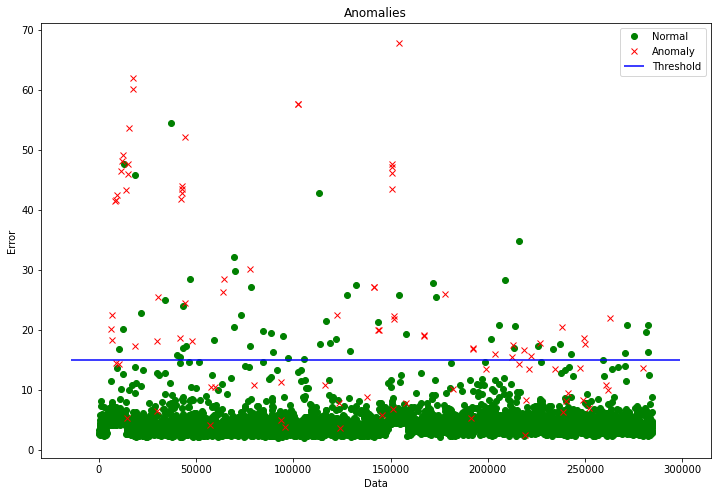

In [30]:
viz.draw_anomaly(y_test, error, threshold)